In [ ]:
# This Colab requires TF 2.5.
!pip install -U "tensorflow>=2.5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

tf.get_logger().setLevel('ERROR')

## 시각화 도구

적절하게 감지된 상자, 키포인트 및 세분화로 이미지를 시각화하기 위해 TensorFlow Object Detection API를 사용합니다. 설치를 위해 리포지토리를 복제합니다.

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4065, done.
remote: Counting objects: 100% (4065/4065), done.
remote: Compressing objects: 100% (3090/3090), done.
remote: Total 4065 (delta 1186), reused 1953 (delta 915), pack-reused 0
Receiving objects: 100% (4065/4065), 54.71 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (1186/1186), done.


Object Detection API 설치하기

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 412.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.

이제 나중에 필요한 종속성을 가져올 수 있습니다.

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### 플로팅을 위해 레이블 맵 데이터 로드하기

레이블 맵은 인덱스 번호를 범주 이름에 대응시키므로, 컨볼루션 네트워크가 `5`를 예측할 때 이것이 `airplane`에 해당한다는 것을 알 수 있습니다. 여기서는 내부 유틸리티 함수를 사용하지만, 정수를 적절한 문자열 레이블에 매핑하는 사전을 반환하는 함수라면 문제 없습니다.

간단히 하기 위해 Object Detection API 코드를 로드한 리포지토리에서 로드하겠습니다.

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
PATH_TO_LABELS = '/content/drive/MyDrive/Graduate2/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 감지 모델을 빌드하고 사전 훈련된 모델 가중치 로드하기

여기서 사용할 객체 감지 모델을 선택합니다. 아키텍처를 선택하면 자동으로 로드됩니다. 나중에 다른 아키텍처를 시도하기 위해 모델을 변경하려면 다음 셀을 변경하고 이어지는 셀을 실행하세요.

**팁:** 선택한 모델에 대한 자세한 내용을 보려면 링크(모델 핸들)로 이동하여 TF Hub에 대한 추가 문서를 읽어보세요. 모델을 선택하면 더 쉽게 처리할 수 있도록 핸들이 출력됩니다.

In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
#SSD ResNet152 V1 FPN 640x640 (RetinaNet152)
model_handle = 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1'

## TensorFlow Hub에서 선택한 모델 로드하기

여기에서는 선택된 모델 핸들만 필요하고 Tensorflow Hub 라이브러리를 사용하여 이 핸들을 메모리에 로드합니다.


In [ ]:
hub_model = hub.load(model_handle)

## 이미지 로드하기

간단한 이미지로 모델을 시도해 보겠습니다. 이를 위해 테스트 이미지 목록을 제공합니다.

궁금하다면 다음과 같이 간단한 시도를 해볼 수 있습니다.

- 자신의 이미지에서 추론을 실행해 봅니다. 이미지를 colab에 업로드하고 아래 셀에서 수행한 것과 같은 방식으로 로드합니다.
- 일부 입력 이미지를 수정하고 여전히 제대로 감지되는지 확인합니다. 여기에서 간단히 이미지를 수평으로 뒤집거나 회색조로 변환하는 몇 가지 간단한 작업을 시도해 볼 수 있습니다(입력 이미지에는 여전히 3개의 채널이 있어야 함).

**주의:** 알파 채널이 있는 이미지를 사용하는 경우, 모델은 3개 채널 이미지를 예상하고 알파는 4번째 채널로 계산됩니다.


In [ ]:
def load_image_into_numpy_array(path):
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [ ]:
#image_path = IMAGES_FOR_TEST[selected_image]
image_path = '/content/drive/MyDrive/Graduate2/cellphone.jpg'
image_np = load_image_into_numpy_array(image_path)

## 추론하기

추론을 수행하려면 TF Hub 로드 모델을 호출하기만 하면 됩니다.

시도해볼 수 있는 작업:

- `result['detection_boxes']`를 출력하고 상자 위치를 이미지의 상자와 일치시킵니다. 좌표는 정규화된 형식(예: [0, 1] 간격)으로 제공됩니다.
- 결과에 있는 다른 출력 키를 검사합니다. 모델 문서 페이지에서 전체 문서를 볼 수 있습니다(브라우저에서 앞서 출력된 모델 핸들을 가리킴).

In [ ]:
# running inference
results = hub_model(image_np)
# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}

## 결과 시각화하기

여기에서는 추론 단계의 사각형(및 가능한 경우 키포인트)을 표시하기 위해 TensorFlow Object Detection API가 필요합니다.

이 방법을 보여주는 전체 문서는 [여기](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)에서 확인할 수 있습니다.

예를 들어, 여기에서 `min_score_thresh`를 다른 값(0과 1 사이)으로 설정하여 더 많이 감지할 수 있게 하거나 더 많은 감지를 필터링할 수 있습니다.

In [ ]:
!pip install opencv-python

In [ ]:
!pip install colorthief

Detected Class: 휴대폰 , Score: 0.5583546
Box: (0.3642304, 0.21979344, 0.76788795, 0.7654613)
RGB: (189, 184, 169)
Dominant Color: 흰색
흰색 휴대폰


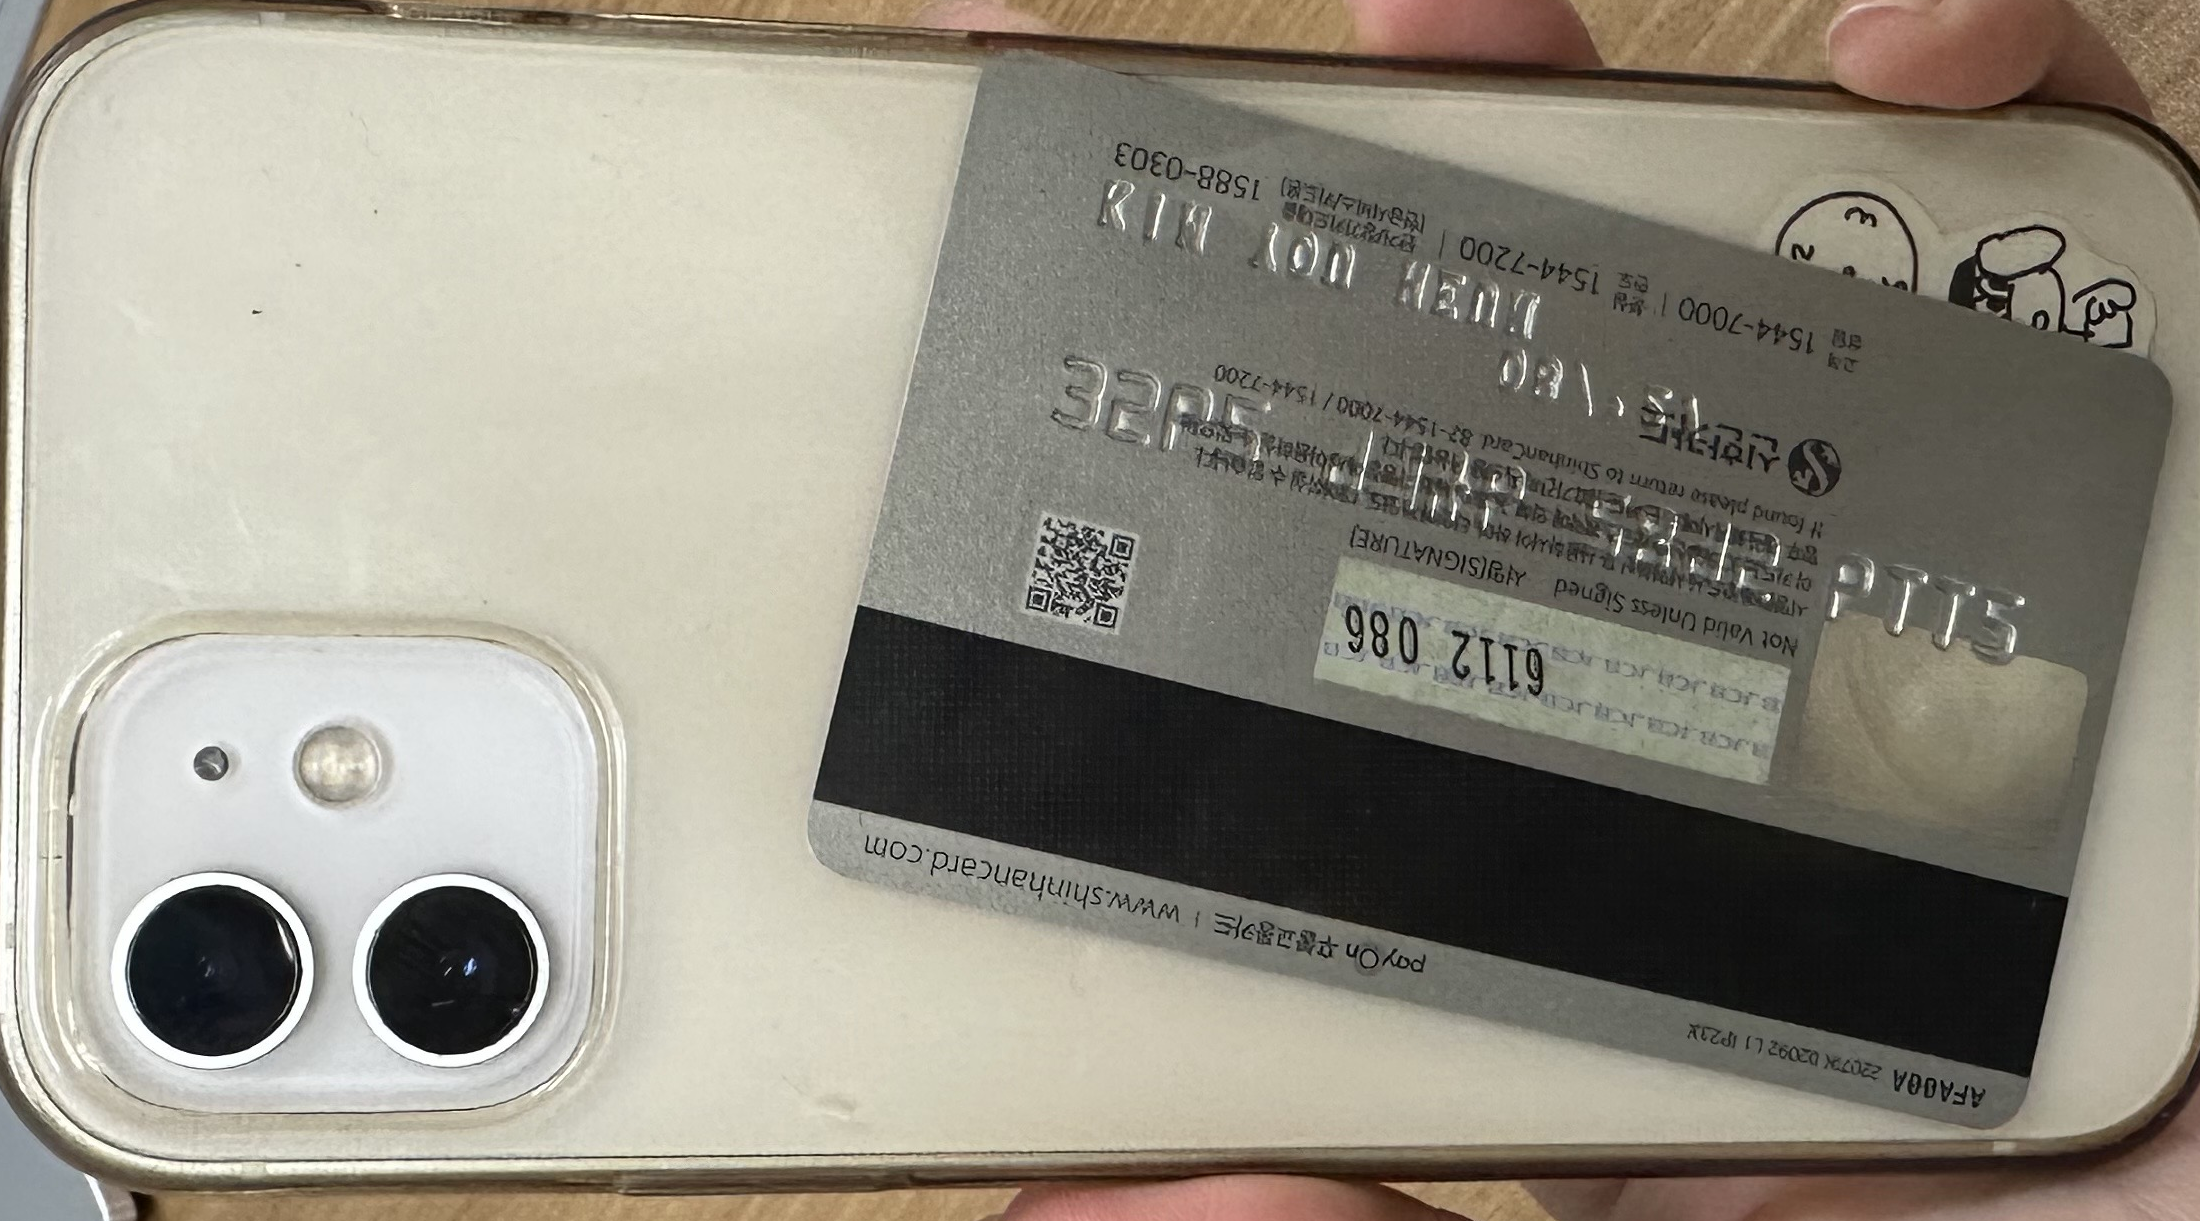

In [ ]:
import cv2
from PIL import Image
from IPython.display import display
from colorthief import ColorThief
import numpy as np
from io import BytesIO

label_id_offset = 0
image_np_with_detections = image_np.copy()

# Detected Class 중 'Person'이 있는지 확인
detected_classes = (result['detection_classes'][0] + label_id_offset).astype(int)
detected_scores = result['detection_scores'][0]

#추가 (person의 index가 사라지기 전 가장 높은 확률의 index 구하기 위해 copy)
detected_classes2 = detected_classes.copy()

# Person이 감지된 경우를 확인하고 제외
person_detected_indices = [i for i, class_id in enumerate(detected_classes) if category_index[class_id]['name'].lower() == 'person']
if person_detected_indices:
    person_image_np = image_np_with_detections.copy()  # 수정
    # Person이 감지된 경우, 다음으로 높은 확률의 물체를 선택
    detected_classes_filtered = np.delete(detected_classes, person_detected_indices)
    detected_scores_filtered = np.delete(detected_scores, person_detected_indices)
    if len(detected_classes_filtered) > 0:
        max_score_index = np.argmax(detected_scores_filtered)
        box = result['detection_boxes'][0][max_score_index]
        detected_classes = np.array([detected_classes_filtered[max_score_index]])
        detected_scores = np.array([detected_scores_filtered[max_score_index]])
    else:
        print("No other objects detected.")

#추가
# 'person'이 제외된 클래스의 원래 인덱스를 구함
original_indices = [i for i, class_id in enumerate(detected_classes2) if i not in person_detected_indices]

if len(detected_classes) > 0:
    max_score_index = np.argmax(detected_scores)

    box = result['detection_boxes'][0][original_indices[0]]
    class_id = int(detected_classes[max_score_index])
    score = detected_scores[max_score_index]

    class_name = category_index[class_id]['name']

    print('Detected Class:', class_name, ', Score:', score)

    # 이미지 크기 얻기
    im_height, im_width, _ = image_np[0].shape

    # bounding box 좌표
    box = tuple(box)
    print('Box:',box)
    ymin, xmin, ymax, xmax = box
    xmin, xmax, ymin, ymax = int(xmin * im_width), int(xmax * im_width), int(ymin * im_height), int(ymax * im_height)

    # 물체 추출
    object_segment = image_np[0][ymin:ymax, xmin:xmax]

    # 결과 출력
    #display(Image.fromarray(cv2.cvtColor(object_segment, cv2.COLOR_RGB2BGR)))  # 추출된 물체 이미지

    # object_segment는 cv2 이미지.
    pil_image = Image.fromarray((object_segment))

    # 임시 파일로 이미지 저장
    temp_image_path = "temp_image.jpg"
    pil_image.save(temp_image_path)

    #ColorThief 객체 생성
    color_thief = ColorThief(temp_image_path)

    #주요 색상 추출
    dominant_color = color_thief.get_color(quality=1)

    def find_closest_color(rgb, color_mapping):
        min_distance = float('inf')
        closest_color = None

        for color, name in color_mapping.items():
            distance = np.linalg.norm(np.array(rgb) - np.array(color))
            if distance < min_distance:
                min_distance = distance
                closest_color = name

        return closest_color

    # RGB 값을 흰색, 검은색 등의 문자열로 변환
    def rgb_to_color_name(rgb):
        color_mapping = {
            (255, 0, 0): "빨간색",
            (255, 165, 0): "주황색",
            (255, 255, 0): "노란색",
            (0, 128, 0): "초록색",
            (0, 0, 255): "파란색",
            (0, 0, 128): "남색",
            (128, 0, 128): "보라색",
            (255,255,255):"흰색"
        }

        return find_closest_color(rgb, color_mapping)

    # 주요 색상 출력
    print('RGB:', dominant_color)
    color_name = rgb_to_color_name(dominant_color)
    print('Dominant Color:', color_name)
    print(color_name, class_name)

    # 결과 출력
    display(Image.fromarray((object_segment)))

    # 임시 파일 삭제
    os.remove(temp_image_path)
else:
    print("No other objects detected.")